# Module

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# Load Data

In [3]:
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')
train_raw.shape, test_raw.shape

((200000, 202), (200000, 201))

In [51]:
del train, test, clf, data
gc.collect()

554

In [4]:
train = train_raw.copy()
test = test_raw.copy()

In [5]:
col_list = train.columns[2:]

In [6]:
train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

In [7]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

In [8]:
test_pb = test.iloc[pb_idx].sort_index().copy()
test_pv = test.iloc[pv_idx].sort_index().copy()

test_real = test_pb.append(test_pv)

In [9]:
data = train.append(test_real)[['ID_code', 'target'] + col_list.tolist()]

# Extract Unique Value in All Data

## filter

In [10]:
# unique_df = data[['ID_code']]
con_df = data[['ID_code']]
con1_df = data[['ID_code']]
con2_df = data[['ID_code']]
con3_df = data[['ID_code']]
con4_df = data[['ID_code']]
con5_df = data[['ID_code']]
con6_df = data[['ID_code']]
con7_df = data[['ID_code']]
con8_df = data[['ID_code']]

In [11]:
for col in tqdm(col_list):
#     unique_df[col] = data[col].map(((data[col].value_counts() == 1) * 1).to_dict())
    con_df[col] = data[col].map((~(data[col].value_counts() == 1) * 1).to_dict())
    con1_df[col] = data[col].map(((data[col].value_counts() == 1) * 1).to_dict())
    con2_df[col] = data[col].map(((data[col].value_counts() == 2) * 1).to_dict())
    con3_df[col] = data[col].map(((data[col].value_counts() == 3) * 1).to_dict())
    con4_df[col] = data[col].map(((data[col].value_counts() == 4) * 1).to_dict())
    con5_df[col] = data[col].map(((data[col].value_counts() == 5) * 1).to_dict())
    con6_df[col] = data[col].map(((data[col].value_counts() == 6) * 1).to_dict())
    con7_df[col] = data[col].map(((data[col].value_counts() == 7) * 1).to_dict())
    con8_df[col] = data[col].map(((data[col].value_counts() == 8) * 1).to_dict())

In [12]:
order_df = data[['ID_code']]
for col in tqdm(col_list):
    temp = data[col].value_counts().sort_index().to_frame()
    order = [0]
    
    for v in temp.iterrows():
        order.append(order[-1] + v[1].values[0])
    
    temp[col] = order[:-1]
    temp = temp.to_dict()[col]

    order_df[col] = data[col].map(temp)

## make data

In [12]:
for col in tqdm(col_list):
#     data[col + '_unique'] = data[col] * unique_df[col]
    data[col + '_con'] = data[col] * con_df[col]
    data[col + '_con1'] = data[col] * con1_df[col]
    data[col + '_con2'] = data[col] * con2_df[col]
    data[col + '_con3'] = data[col] * con3_df[col]
    data[col + '_con4'] = data[col] * con4_df[col]
    data[col + '_con5'] = data[col] * con5_df[col]
    data[col + '_con6'] = data[col] * con6_df[col]
    data[col + '_con7'] = data[col] * con7_df[col]
    data[col + '_con8'] = data[col] * con8_df[col]

In [13]:
for col in tqdm(col_list):
#     data.loc[data[col + '_unique']==0, col + '_unique'] = np.nan
    data.loc[data[col + '_con']==0, col + '_con'] = np.nan
    data.loc[data[col + '_con1']==0, col + '_con1'] = np.nan
    data.loc[data[col + '_con2']==0, col + '_con2'] = np.nan
    data.loc[data[col + '_con3']==0, col + '_con3'] = np.nan
    data.loc[data[col + '_con4']==0, col + '_con4'] = np.nan
    data.loc[data[col + '_con5']==0, col + '_con5'] = np.nan
    data.loc[data[col + '_con6']==0, col + '_con6'] = np.nan
    data.loc[data[col + '_con7']==0, col + '_con7'] = np.nan
    data.loc[data[col + '_con8']==0, col + '_con8'] = np.nan

In [14]:
for col in tqdm(col_list):
    data[col + '_con_multi_counts'] = data[col + '_con'] * data[col].map(data[col].value_counts().to_dict())

In [72]:
for col in tqdm(col_list):
    data[col + '_con_order'] = con_df[col] * order_df[col]

In [73]:
for col in tqdm(col_list):
    data.loc[data[col + '_con_order']==0, col + '_con_order'] = np.nan

In [74]:
for col in tqdm(col_list):
    data[col + '_unique_order'] = unique_df[col] * order_df[col]

In [ ]:
for col in tqdm(col_list):
    data.loc[data[col + '_unique_order']==0, col + '_unique_order'] = np.nan

In [15]:
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_con,var_0_con1,var_0_con2,var_0_con3,var_0_con4,var_0_con5,var_0_con6,var_0_con7,var_0_con8,var_1_con,var_1_con1,var_1_con2,var_1_con3,var_1_con4,var_1_con5,var_1_con6,var_1_con7,var_1_con8,var_2_con,var_2_con1,var_2_con2,var_2_con3,var_2_con4,var_2_con5,var_2_con6,var_2_con7,var_2_con8,var_3_con,var_3_con1,var_3_con2,var_3_con3,var_3_con4,var_3_con5,var_3_con6,var_3_con7,var_3_con8,var_4_con,var_4_con1,var_4_con2,var_4_con3,var_4_con4,var_4_con5,var_4_con6,var_4_con7,var_4_con8,var_5_con,var_5_con1,var_5_con2,...,var_194_con4,var_194_con5,var_194_con6,var_194_con7,var_194_con8,var_195_con,var_195_con1,var_195_con2,var_195_con3,var_195_con4,var_195_con5,var_195_con6,var_195_con7,var_195_con8,var_196_con,var_196_con1,var_196_con2,var_196_con3,var_196_con4,var_196_con5,var_196_con6,var_196_con7,var_196_con8,var_197_con,var_197_con1,var_197_con2,var_197_con3,var_197_con4,var_197_con5,var_197_con6,var_197_con7,var_197_con8,var_198_con,var_198_con1,var_198_con2,var_198_con3,var_198_con4,var_198_con5,var_198_con6,var_198_con7,var_198_con8,var_199_con,var_199_con1,var_199_con2,var_199_con3,var_199_con4,var_199_con5,var_199_con6,var_199_con7,var_199_con8,var_0_con_multi_counts,var_1_con_multi_counts,var_2_con_multi_counts,var_3_con_multi_counts,var_4_con_multi_counts,var_5_con_multi_counts,var_6_con_multi_counts,var_7_con_multi_counts,var_8_con_multi_counts,var_9_con_multi_counts,var_10_con_multi_counts,var_11_con_multi_counts,var_12_con_multi_counts,var_13_con_multi_counts,var_14_con_multi_counts,var_15_con_multi_counts,var_16_con_multi_counts,var_17_con_multi_counts,var_18_con_multi_counts,var_19_con_multi_counts,var_20_con_multi_counts,var_21_con_multi_counts,var_22_con_multi_counts,var_23_con_multi_counts,var_24_con_multi_counts,var_25_con_multi_counts,var_26_con_multi_counts,var_27_con_multi_counts,var_28_con_multi_counts,var_29_con_multi_counts,var_30_con_multi_counts,var_31_con_multi_counts,var_32_con_multi_counts,var_33_con_multi_counts,var_34_con_multi_counts,var_35_con_multi_counts,var_36_con_multi_counts,var_37_con_multi_counts,var_38_con_multi_counts,var_39_con_multi_counts,var_40_con_multi_counts,var_41_con_multi_counts,var_42_con_multi_counts,var_43_con_multi_counts,var_44_con_multi_counts,var_45_con_multi_counts,var_46_con_multi_counts,var_47_con_multi_counts,var_48_con_multi_counts,var_49_con_multi_counts,var_50_con_multi_counts,var_51_con_multi_counts,var_52_con_multi_counts,var_53_con_multi_counts,var_54_con_multi_counts,var_55_con_mu

# Model

In [16]:
train = data[~data.target.isna()]
test = data[data.target.isna()]

In [17]:
target = train['target']

In [18]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 8
}

* 0.92288
* 0.92308

In [19]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 500000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 3500)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
            
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.891468	valid_1's auc: 0.883466
[10000]	training's auc: 0.913674	valid_1's auc: 0.904584
[15000]	training's auc: 0.923286	valid_1's auc: 0.912807
[20000]	training's auc: 0.928619	valid_1's auc: 0.916937
[25000]	training's auc: 0.932244	valid_1's auc: 0.919205
[30000]	training's auc: 0.934968	valid_1's auc: 0.920512
[35000]	training's auc: 0.937194	valid_1's auc: 0.921131
[40000]	training's auc: 0.939109	valid_1's auc: 0.921455
[45000]	training's auc: 0.940843	valid_1's auc: 0.921573
Early stopping, best iteration is:
[43944]	training's auc: 0.940483	valid_1's auc: 0.921616
CV score: 0.92162 
fold n°1
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.891659	valid_1's auc: 0.886056
[10000]	training's auc: 0.913253	valid_1's auc: 0.906328
[15000]	training's auc: 0.923024	valid_1's auc: 0.914419
[20000]	training's auc: 0.928439	valid_1's auc: 0.918269
[250

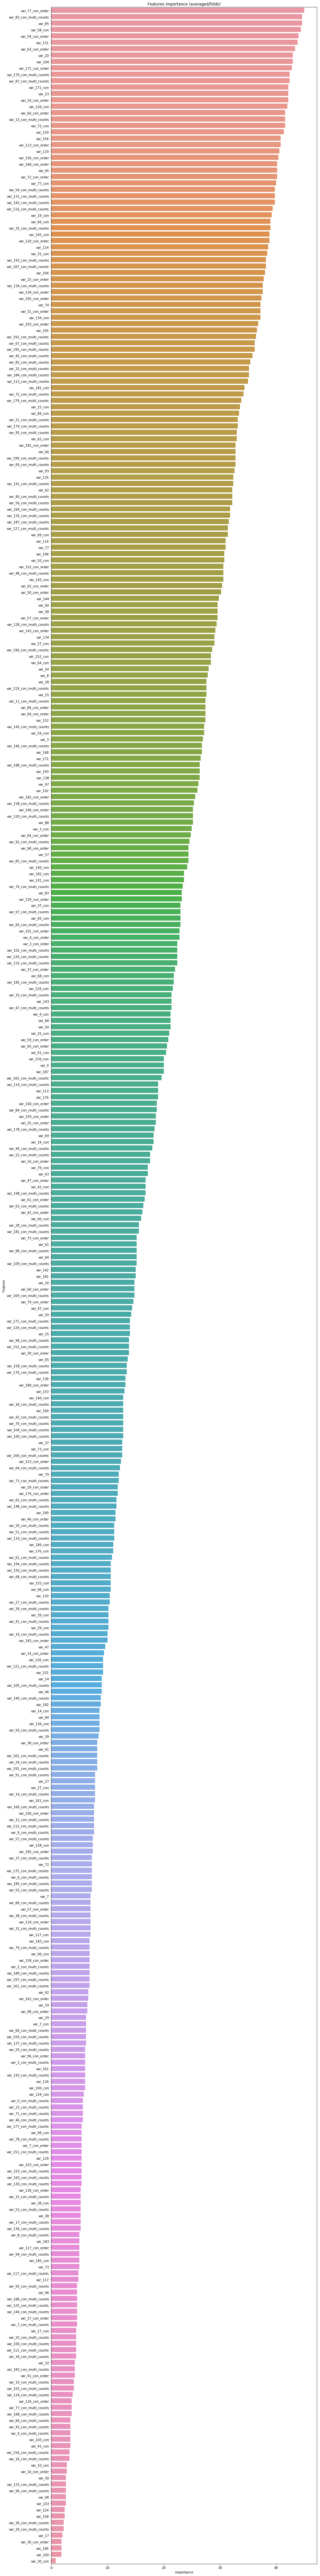

In [41]:
best_features = (feature_importance[["Feature", "importance"]]
                    .groupby("Feature")
                    .mean()
                    .sort_values(by="importance", ascending=False)[400:])

plt.figure(figsize=(14,112))
sns.barplot(x="importance", y="Feature", data=best_features.reset_index())
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [79]:
test['target'] = predictions_lgb
sub = pd.read_csv('./data/sample_submission.csv')
unchange = sub[~sub.ID_code.isin(test.ID_code)]
sub = test[['ID_code', 'target']].append(unchange).sort_index()

In [84]:
sample = pd.read_csv('./data/sub_lgb_5fold5aug_concategory_cv_0.9242224159538349.csv')

In [87]:
sample['new_target'] = sub.target

In [90]:
sample[sample.new_target != 0].corr()

,target,new_target
target,1.000000,0.991132
new_target,0.991132,1.000000


In [93]:
sub.to_csv('./data/sub_lgb_noAug_cv_0.923.csv', index=False)

In [18]:
for col in tqdm(col_list):
    data[col + '_con_category'] = np.around(data[col + '_con'], 0)
#     data[col + '_unique_category'] = np.around(data[col + '_unique'], 0)

In [19]:
for col in tqdm(col_list):
    le = LabelEncoder()
    le.fit(data[col + '_con_category'].fillna(0))
    data[col + '_con_category'] = le.transform(data[col + '_con_category'].fillna(0))

In [128]:
for col in tqdm(col_list):
    le = LabelEncoder()
    le.fit(data[col + '_unique_category'].fillna(0))
    data[col + '_unique_category'] = le.transform(data[col + '_unique_category'].fillna(0))

In [129]:
for col in tqdm(col_list):
    data[col + '_unique_category'] = data[col + '_unique_category'].astype('category')

In [20]:
data = pd.get_dummies(data, columns=[col + '_con_category' for col in col_list])